
# Agent Results Visulization

## Imports

In [1]:
cd ..

/home/oscarpindaro/git_projects/RLithium-0


In [2]:
from mushroom_rl.algorithms.value import FQI
import numpy as np
import os
import json
from rse_lib.environment.MushroomBatteryEnv import MushroomBatteryEnv
from rse_lib.environment.data_generators import DataGenerator
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib
import pickle as pkl
import math
import seaborn as sns
from rse_lib.utils.plotting import *
import tikzplotlib
from scipy.interpolate import make_interp_spline
%matplotlib inline

## Overview
This notebook contains the visualization of the results of the agent trained. 

## Load and PV Profiles
This section plots the profiles of the photo-voltaic panel and of the house. The former produces at each time step electric power, while the latter requests at each time step power. 

In [3]:
IMAGES_PATH = "notebooks/images/"
save_fig = False
save_fig_mat = False
# font = {'size'   : 14}
# matplotlib.rc('font', **font)

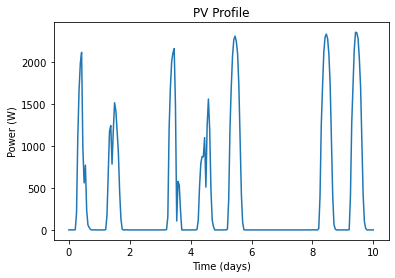

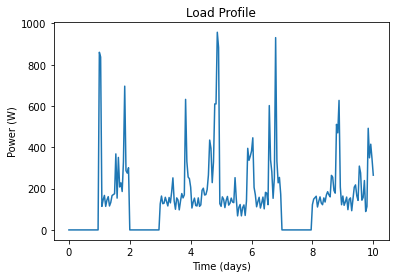

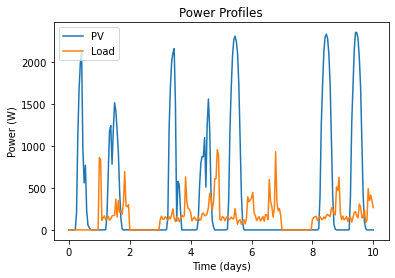

In [6]:
d = DataGenerator(seed=1234)
pv_profile = d.create_pv_profile(1)
load_profile = d.create_load_profile(1)
max_consumption = np.max(load_profile)
pv_profile = pv_profile*max_consumption
days = 10
time = np.linspace(0, 24*days, 24*days+1)/24
day = 100
start = day*24
end = start + 24*days+1
fig, ax = plt.subplots()
ax.plot(time, pv_profile[start:end])
ax.set_title("PV Profile")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Power (W)")
if save_fig:
    tikzplotlib.save(os.path.join(IMAGES_PATH, "PV.tikz"))
if save_fig_mat:
    fig.savefig(os.path.join(IMAGES_PATH, "PV_profile.pdf"), dpi=fig.dpi,  bbox_inches="tight")


fig, ax = plt.subplots()
ax.plot(time, load_profile[start:end])
ax.set_title("Load Profile")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Power (W)")
if save_fig:
    tikzplotlib.save(os.path.join(IMAGES_PATH, "Load.tikz"))
if save_fig_mat:
    fig.savefig(os.path.join(IMAGES_PATH, "Load_profile.pdf"), dpi=fig.dpi, bbox_inches="tight")

fig, ax = plt.subplots()
ax.plot(time,pv_profile[start:end])
ax.plot(time, load_profile[start:end])
ax.set_title("Power Profiles")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Power (W)")
ax.legend(["PV", "Load"])
if save_fig:
    tikzplotlib.save(os.path.join(IMAGES_PATH, "PV_Load.tikz"))
if save_fig_mat:
    fig.savefig(os.path.join(IMAGES_PATH, "PV_Load_profile.pdf"), dpi=fig.dpi,  bbox_inches="tight")
    
    
plt.show()


## Agent results
A section with information about agent and kpi performance on the environment.

In [7]:
name = "lowCostLinearThesis"
BASE_PATH = "experiment_folder/FQI/results/{}_0/".format(name)
agent_path = os.path.join(BASE_PATH, "agent.msh")
json_path = os.path.join(BASE_PATH, "{}.json".format(name))
# load configuration file
with open(json_path) as f:
    conf = json.load(f)
seed = conf["test_seed"]
name = conf["name"]
env_conf = conf["environment"]
env = MushroomBatteryEnv(name=name, seed=seed, experiment_params=env_conf)
# load agent file
try:
    agent_path = os.path.join(BASE_PATH,"agent.msh")
    agent = FQI.load(agent_path)
except Exception as e:
    print(e)
# load transitions
pkl_filename = "transitions.pkl"
with open(os.path.join(BASE_PATH, pkl_filename), "rb") as f:
    transitions = pkl.load(f)
pkl_filename = "transitions_Only_grid.pkl"
with open(os.path.join(BASE_PATH, pkl_filename), "rb") as f:
    transitions_only_grid = pkl.load(f)
pkl_filename = "transitions_Soc20-80.pkl"
with open(os.path.join(BASE_PATH, pkl_filename), "rb") as f:
    transitions_soc2080 = pkl.load(f)
# load actions    
pkl_filename = "actions.pkl"
with open(os.path.join(BASE_PATH, pkl_filename), "rb") as f:
    actions = pkl.load(f)
# load actuated actions
pkl_filename = "actuated_actions.pkl"
with open(os.path.join(BASE_PATH, pkl_filename), "rb") as f:
    actuated_actions = pkl.load(f)
result_name = "result.json"
with open(os.path.join(BASE_PATH, result_name)) as f:
    results = json.load(f)
result_kpi_name = "result_kpi.json"
with open(os.path.join(BASE_PATH, result_kpi_name)) as f:
    results_kpi = json.load(f)

In [8]:
indexes = env.env.state_tracker.get_indexes()

The agent is evaluated with respect to different KPIs:
* **J**: The cumulative reward value
* **reward**: The real economic gain that considers degradation and the profit made while exchanging energy with the electric grid
* **batter_cost**: the amount of battery value lost during the episode. It depends on the percantage wrt to maximum degradation of SoH loss
* **energy_profit**: the profit made while exchanging energy with the electric grid
* **delta_soh**: variation of soh experienced during the episode

In [9]:
print("J",results["AGENT"]["J"]["mean"])
print("reward",results["AGENT"]["reward"]["mean"])
print("battery_cost",results["AGENT"]["battery_cost"]["mean"])
print("energy_profit",results["AGENT"]["energy_profit"]["mean"])
print("delta_soh", results["AGENT"]["delta_soh"]["mean"], "( normalized =", results["AGENT"]["delta_soh"]["mean"]*5,")" )

J -1798.6443557092018
reward -2295.3159777670926
battery_cost -1680.539199304454
energy_profit -614.7767784626259
delta_soh 0.12448438513366322 ( normalized = 0.6224219256683161 )


The agent performances are compared against three baselines:
* **SoC20-80**: policy that keeps the state of charge between 20% and 80%
* **Only_battery**: policy that uses the battery when possible, both while charging and discharging
* **Only_grid**: policy that avoids battery cycling

In [10]:
print_values = False
if print_values:
    for kpi_name in results_kpi:
        J = results_kpi[kpi_name]["J"]["mean"]
        reward = results_kpi[kpi_name]["reward"]["mean"]
        battery_cost =results_kpi[kpi_name]["battery_cost"]["mean"]
        energy_profit =results_kpi[kpi_name]["energy_profit"]["mean"]
        delta_soh = results_kpi[kpi_name]["delta_soh"]["mean"]
        print("{}\nJ={}\ngain_kpi={}\nbattery_cost={}\nenergy_profit={}\ndelta_soh={}\n".format(kpi_name,
                                                                                            J, reward, 
                                                                                            battery_cost,
                                                                                           energy_profit,
                                                                                           delta_soh))
print_best_strategy(BASE_PATH, "reward")

Printing each value of reward and find best
No fixed action file found
AGENT -- mean_reward = -2295.3159777670926
Soc20-80 -- mean_reward = -2454.985573531353
Only_battery -- mean_reward = -2365.925289591875
Only_grid -- mean_reward = -2354.149130676077
The best strategy was AGENT


## Performance Visualization
The performance of the agent are visualized both in absolute value and with respect to the baseline **SoC20-80**.

No fixed action file found
No fixed action file found


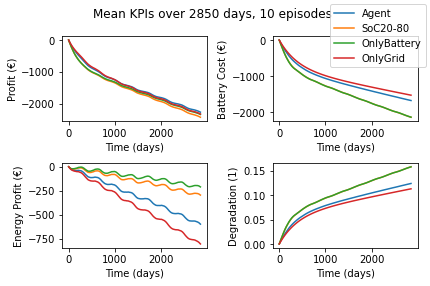

In [11]:
fig = visualize_same_figure(BASE_PATH, diff=False, use_baseline=False, 
                            mult_soh=1, save=False, filename="kpis")
if save_fig:
    tikzplotlib.save(os.path.join(IMAGES_PATH, "kpis.tikz"), figure=fig)
if save_fig_mat:
    #font = {'size'   : 8}
    #matplotlib.rc('font', **font)
    fig.savefig(os.path.join(IMAGES_PATH, "kpis.pdf"), dpi=fig.dpi,  bbox_inches="tight")

No fixed action file found
No fixed action file found


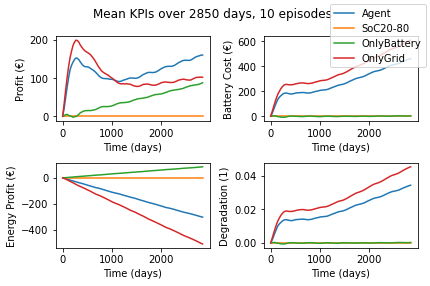

In [12]:
fig = visualize_same_figure(BASE_PATH, diff=True, use_baseline=True, mult_soh=1, save=False, filename="kpis_diff")
if save_fig:
    tikzplotlib.save(os.path.join(IMAGES_PATH, "kpis_diff.tikz"), figure=fig)
if save_fig_mat:
    fig.savefig(os.path.join(IMAGES_PATH, "kpis_diff.pdf"), dpi=fig.dpi,  bbox_inches="tight")

## 1-D Q value visualization
The Q-value is an estimation of the long term reward. The following plots are a visualization of the variation of the Q-value wrt some specific variables. The Q-value is sampled from real transition. The median is plotted to visualize the trend and the first and third quartile are used to give an idea on the spread that this function has wrt the current variables. A high interquartile range means that the variable is not able to capture alone a correlation.


In [32]:
def get_sim_actions(qvalues, tol=0.01):
    maxQ = np.max(qvalues, axis=1)
    argmaxQ = np.argmax(qvalues, axis=1)
    qvalue_filtered = qvalues.copy()
    min_actions = np.zeros_like(maxQ)
    max_actions = np.zeros_like(maxQ)
    # filter q value inside a tolerance of tol
    comp_value = 1000
    for i in range(len(maxQ)):
        max_qvalue = maxQ[i]
        row = qvalue_filtered[i,:]
        perc_value = abs(max_qvalue*tol)
        row[row < (max_qvalue - perc_value)] = comp_value
        row[row > (max_qvalue + perc_value)] = comp_value
        # find smallest action
        min_action = argmaxQ[i]
        for j in range(argmaxQ[i],-1,-1):
            min_action = j
            min_actions[i] = j
            if row[j] > comp_value-1e-6 and row[j] < comp_value+ 1e-6:
                break;
        max_action = argmaxQ[i]
        for k in range(argmaxQ[i], len(row)):
            max_action = k
            max_actions[i] = k
            if row[k] > comp_value-1e-6 and row[k] < comp_value+1e-6:
                break
    return min_actions, max_actions
        
    

def bidimensional_qvalue(agent, base_state, var_idx, var_name, min_val=0,
                         max_val=1, n_samples=1001, tol=0.1):
    predictor = agent.approximator._impl
    var_span = np.linspace(min_val, max_val, n_samples)
    states = np.ones((len(var_span), len(base_state)))
    states = states*base_state
    states[:,indexes[var_name]] = var_span
    # predictions
    predictions = predictor.predict(states)
    reshaped_var = var_span.reshape(-1,1)
    maxQ = np.max(predictions, axis=1)
    maxQ_predicted = LinearRegression().fit(reshaped_var, maxQ).predict(reshaped_var)
    maxA = np.argmax(predictions,axis=1)
    maxA_predicted = LinearRegression().fit(reshaped_var, maxA).predict(reshaped_var)
    min_actions, max_actions = get_sim_actions(predictions, tol)
    fig, ax = plt.subplots(2,1, sharex=True)
    ax[0].plot(var_span, maxQ)
    ax[0].plot(var_span, maxQ_predicted)
    ax[0].set_ylabel("maxQ_value")
    color = "forestgreen"
    ax[1].fill_between(var_span, min_actions, max_actions, alpha=0.2, color=color)
    ax[1].plot(var_span, maxA, color=color)
    #ax[1].plot(var_span, maxA_predicted)
    

    
    #spline = make_interp_spline(var_span, min_actions)
    #X_ = np.linspace(var_span.min(), var_span.max(), n_samples*100)
    #Y_ = spline(X_)
    #ax[1].plot(X_, Y_)
    #ax[1].plot(var_span, min_actions)
    #ax[1].plot(var_span, max_actions)
    

    
    ax[1].set_ylim([0-1,10+1])
    ax[1].set_ylabel("Action")
    if var_name == "SoC" or var_name == "DoD":
        #ax[1].set_xticks(np.linspace(0,1,11))
        pass
    fig.text(0.5, 0.0, var_name, ha='center')
    fig.suptitle("Q-value wrt {}".format(var_name))
    fig.tight_layout()
    plt.show()
    return fig

    

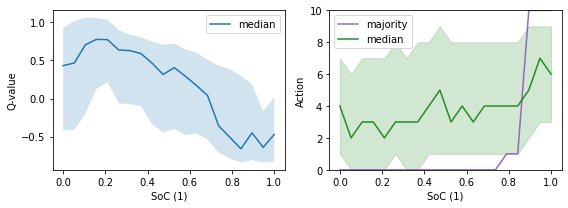

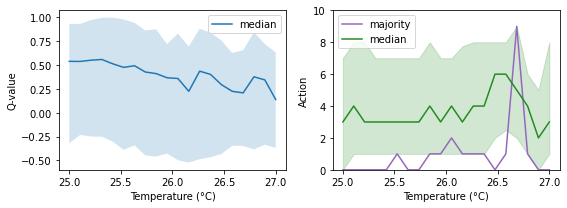

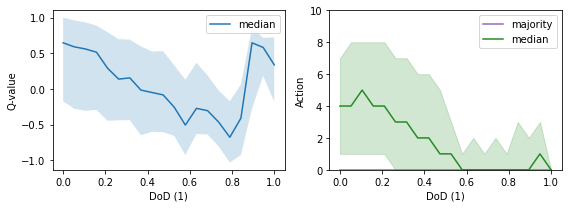

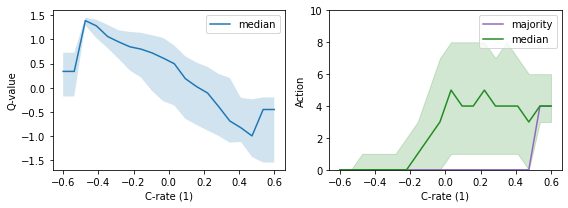

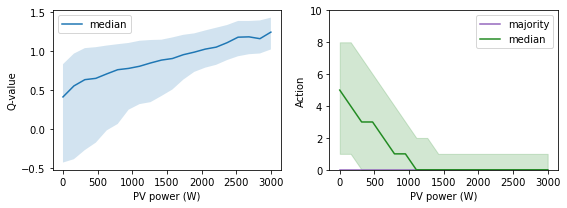

In [33]:
predictor = agent.approximator._impl
states = np.array([tr[0] for tr in transitions[0]])
# ******************** STATES
t = [x for ep in transitions for x in ep]

states = [x[0] for x in t]
states = np.array(states)



#for i in range(1, len(transitions)):
#    states += np.array([tr[0] for tr in transitions[i]])
# *********************************
#states = states[states[:,indexes["C_rate"]] <0 ]
min_values = [0,25,0,-0.6,0]
max_values = [1, 27,1, 0.6, 3000]
variables = ["SoC", "Temp","DoD", "C_rate", "PV_power"]
for i in range(len(variables)):
    #font = {'size'   : 11}
    #matplotlib.rc('font', **font)
    var = variables[i]
    n_samples =20
    min_value = min_values[i]
    max_value = max_values[i]
    var_values = np.linspace(min_value, max_value,n_samples)
    qvalues =predictor.predict(states)
    maxQ = np.max(qvalues, axis=1)
    maxA = np.argmax(qvalues,axis=1)
    q_filtered = np.zeros_like(var_values)
    q_filtered_median = np.zeros_like(var_values)
    q_var = np.zeros_like(var_values)
    q_quantile_1 = np.zeros_like(var_values)
    q_quantile_3 = np.zeros_like(var_values)
    action_filtered = np.zeros_like(var_values)
    action_var = np.zeros_like(var_values)
    action_quantile_1 = np.zeros_like(var_values)
    action_quantile_3 = np.zeros_like(var_values)
    action_median =np.zeros_like(var_values)
    action_majority = np.zeros_like(var_values)
    for i in range(n_samples):
        start =min_value + i /n_samples*(max_value-min_value)
        end = min_value +(i+1)/n_samples*(max_value-min_value)
        arr_var = states[:,indexes[var]]
        # q value
        filtered_var = maxQ[(arr_var >= start ) & (arr_var< end)]
        if len(filtered_var) > 0:
            filtered_q_value = np.mean(filtered_var)
            filtered_q_median = np.median(filtered_var)
            var_value = np.var(filtered_var)
            quantile_1 = np.quantile(filtered_var, 0.25)
            quantile_3 = np.quantile(filtered_var, 0.75)
        q_filtered[i]= filtered_q_value
        q_filtered_median[i] = filtered_q_median
        q_var[i] = var_value
        q_quantile_1[i] = quantile_1
        q_quantile_3[i] = quantile_3
        # action
        filtered_actions = maxA[(arr_var >= start ) & (arr_var< end)]
        if len(filtered_actions) > 0:
            f_action_mean = np.mean(filtered_actions)
            f_action_median = np.median(filtered_actions)
            f_action_majority = np.argmax(np.bincount(filtered_actions))
            action_var_value = np.var(filtered_var)
            a_quantile_1 = np.quantile(filtered_actions, 0.25)
            a_quantile_3 = np.quantile(filtered_actions, 0.75)
        action_filtered[i]= f_action_mean
        action_var[i] = action_var_value
        action_quantile_1[i] = a_quantile_1
        action_quantile_3[i] = a_quantile_3
        action_median[i] = f_action_median
        action_majority[i] = f_action_majority
    
    switch_dict={
        "SoC":"SoC (1)",
        "Temp":"Temperature (°C)",
        "DoD": "DoD (1)",
        "C_rate":"C-rate (1)",
        "PV_power":"PV power (W)"
    }
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(8, 3)
    #fig.suptitle("Q-value and Actions")
    #ax[0].plot(var_values, q_filtered)
    ax[0].fill_between(var_values, q_quantile_1, q_quantile_3, alpha=0.2)
    ax[0].plot(var_values, q_filtered_median)
    ax[0].legend(["median"])
    #ax[0].set_title("Q-value")
    ax[0].set_ylabel("Q-value")
    ax[0].set_xlabel(switch_dict[var])
    color = "forestgreen"
    #ax[1].plot(var_values, action_filtered,color = color)
    ax[1].plot(var_values, action_majority, color="tab:purple")
    ax[1].plot(var_values, action_median, color = color)
    ax[1].set_ylim([0,10])
    ax[1].fill_between(var_values, action_quantile_1, action_quantile_3, alpha=0.2, color=color)
    ax[1].legend([ "majority","median"])
    #ax[1].set_title("Action")
    ax[1].set_ylabel("Action")

    ax[1].set_xlabel(switch_dict[var])

    plt.tight_layout()
    
    
    plt.show()
    if save_fig:
        tikzplotlib.save(os.path.join(IMAGES_PATH, "{}_qvalue_action.tikz".format(var)), 
                         figure=fig)
    if save_fig_mat:
        fig.savefig(os.path.join(IMAGES_PATH, "{}_qvalue_action.pdf".format(var)), 
                    dpi=fig.dpi,  bbox_inches="tight")

## 2-D Q-value visualization
The same reasoning done before is applied with 2 different variables. The visualization is performed with an heatmap that for each SoC level tells the requency at which each action is picked.


In [19]:
def qvalue_3d(agent, indexes, var1_name, var2_name, var1_len, var2_len, transitions,
              var1_min=0, var2_min=1, var1_max=0, var2_max=1, qmin=None, qmax=None, episode_idx=None, charge=None):
    
    if episode_idx is None:
        t = [x for ep in transitions for x in ep]
    else:
        t = transitions[episode_idx]
    try:
        if charge is True and indexes is not None:
            t = [x for x in t if x[0][indexes["C_rate"]] < 0]
        elif charge is False and indexes is not None:
            t = [x for x in t if x[0][indexes["C_rate"]] > 0]
        else:
            t = [x for x in t]
    except Exception as e:
        print(e)

    states = [x[0] for x in t]
    states = np.array(states)
    
    var1_index = indexes[var1_name]
    var2_index = indexes[var2_name]
    predictor = agent.approximator._impl
    var1_span = np.linspace(var1_min, var1_max, var1_len)
    
    var2_span= np.linspace(var2_min, var2_max, var2_len)
    var1, var2 = np.meshgrid(var1_span, var2_span)
    qvalues =predictor.predict(states)
    maxQ = np.max(qvalues, axis=1)
    maxA = np.argmax(qvalues,axis=1)
    q_filtered_values = np.zeros((var1_len, var2_len))
    action_filtered_values = np.zeros((var1_len, var2_len))
    
    for i in range(0,var1_len):
        start_1 = var1_min + i/var1_len*(var1_max-var1_min)
        end_1 =  var1_min + (i+1)/var1_len*(var1_max-var1_min)
        arr_var1 = states[:,indexes[var1_name]]
        for j in range(0,var2_len):
            start_2 = var2_min + j/var2_len*(var2_max-var2_min)
            end_2 =  var2_min + (j+1)/var2_len*(var2_max-var2_min)
            arr_var2 = states[:,indexes[var2_name]]
            filtered_var = maxQ[(arr_var1 > start_1 ) & (arr_var1< end_1) 
                               & (arr_var2 > start_2 ) & (arr_var2< end_2)]
            filtered_action = maxA[(arr_var1 > start_1 ) & (arr_var1< end_1) 
                               & (arr_var2 > start_2 ) & (arr_var2< end_2)]
            if len(filtered_var) > 0:
                filtered_q_value = np.median(filtered_var)
                #actions
                filtered_action_value = np.median(filtered_action)
            else:
                filtered_q_value = None
                #actions
                filtered_action_value = None
            q_filtered_values[i][j] = filtered_q_value
            #action
            action_filtered_values[i][j] = filtered_action_value
    
    q_filtered_values = q_filtered_values.transpose()
    action_filtered_values = action_filtered_values.transpose()
    cmap=cm.coolwarm
    """

    # Q-value
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf =ax.plot_surface(var1, var2, q_filtered_values, cmap=cmap,linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.invert_yaxis()
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(var1_name)
    ax.set_ylabel(var2_name)
    ax.set_zlabel("max Q-value")
    ax.set_xlim([0,1])
    fig.tight_layout()
    plt.show()

    # Action
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(var1, var2, action_filtered_values,  cmap=cmap,linewidth=0, antialiased=False)

    ax.zaxis.set_major_locator(LinearLocator(11))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(var1_name)
    ax.set_ylabel(var2_name)
    ax.set_zlabel("Action")
    fig.tight_layout()
    plt.show()
    """
    switch_dict={
        "SoC":"SoC (1)",
        "Temp":"Temperature (°C)",
        "DoD": "DoD (1)",
        "C_rate":"C-rate (1)",
        "PV_power":"PV power (W)"
    }
    
    import seaborn as sns
    import pandas as pd
    fig1, ax = plt.subplots()
    xticks = var1_span
    xticks = [format(i,".2f") for i in xticks]
    yticks=var2_span
    yticks = [format(i,".2f") for i in yticks]
    ax = sns.heatmap(q_filtered_values, ax=ax, cmap=cmap, vmin=qmin,
                vmax=qmax, xticklabels=xticks, yticklabels=yticks, square=False)
    ax.set_xlabel(switch_dict[var1_name])
    ax.set_ylabel(switch_dict[var2_name])
    ax.invert_yaxis()
    ax.set_title("Q-value Distribution")

    
    fig2, ax = plt.subplots()
    ax =sns.heatmap(action_filtered_values, ax=ax, cmap=cmap, vmin=0, vmax=10,
               xticklabels=xticks, yticklabels=yticks, square=False)
    ax.set_xlabel(switch_dict[var1_name])
    ax.set_ylabel(switch_dict[var2_name])
    ax.invert_yaxis()
    ax.set_title("Action Distribution")
    return fig1, fig2

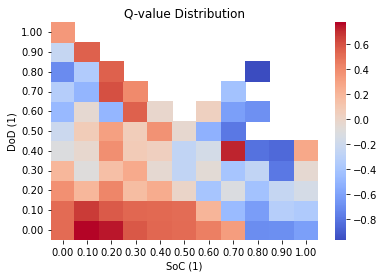

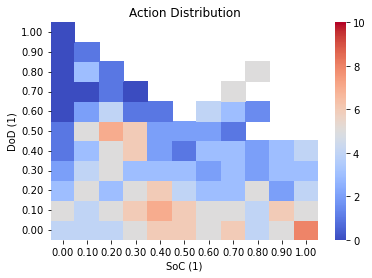

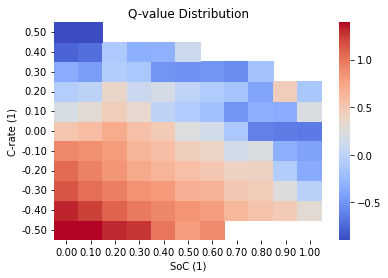

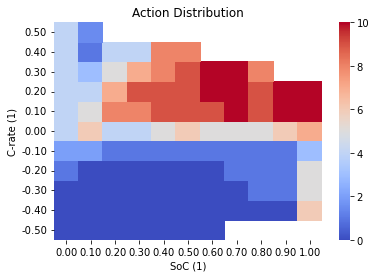

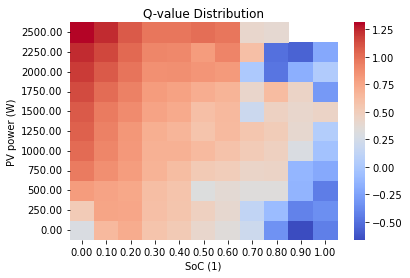

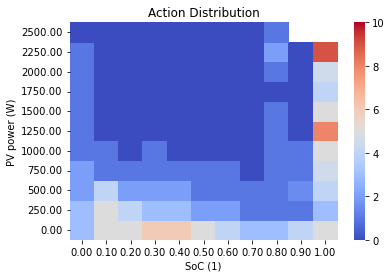

In [20]:
couples = [["SoC", "DoD"], ["SoC", "C_rate"], ["SoC", "PV_power"] ]
mins = [[0, 0], [0, -0.5], [0, 0] ]
maxs = [[1, 1], [1, 0.5], [1, 2500]]
lens = [[11, 11], [11, 11], [11, 11]]
for i in range(len(couples)):
    name1=couples[i][0]
    name2=couples[i][1]
    var1_idx = indexes[name1]
    var2_idx = indexes[name2]
    var1_len = lens[i][0]
    var2_len = lens[i][1]
    var1_min = mins[i][0]
    var1_max = maxs[i][0]
    var2_min = mins[i][1]
    var2_max = maxs[i][1]
    #font = {'size'   : 12}
    #matplotlib.rc('font', **font)
    fig1, fig2 =qvalue_3d(agent, indexes, name1, name2,
              var1_len=var1_len, var2_len=var2_len, transitions=transitions, var1_min=var1_min,
              var2_min=var2_min,var1_max =var1_max, var2_max=var2_max)
    if save_fig:
        name1 =name1.replace("_", "-")
        name2= name2.replace("_", "-")
        tikzplotlib.save(os.path.join(IMAGES_PATH, "{}-{}-heatmap-qvalue.tikz".format(name1,name2)),
                         figure=fig1 )
        tikzplotlib.save(os.path.join(IMAGES_PATH, "{}-{}-heatmap-action.tikz".format(name1,name2)),
                     figure=fig2 )
    if save_fig_mat:

        fig1.savefig(os.path.join(IMAGES_PATH, "{}_{}_heatmap_qvalue.pdf".format(name1,name2)), 
                    dpi=fig.dpi,  bbox_inches="tight")
        fig2.savefig(os.path.join(IMAGES_PATH, "{}_{}_heatmap_action.pdf".format(name1,name2)), 
                    dpi=fig.dpi,  bbox_inches="tight")

## Q-value time visualization
The trend of the Q-value is also represented wrt time. The peaks of the Q-value are concentrated in the season with most sun exposure and during the day. Therefore, an annual and daily periodic components can be found

In [21]:
def qtime_subplot(transitions, agent, indexes):
    predictor = agent.approximator._impl
    states = np.array([tr[0] for tr in transitions[0]])
    for i in range(1, len(transitions)):
        states += np.array([tr[0] for tr in transitions[i]])
    states = states/len(transitions)
    qvalues =predictor.predict(states)
    maxQ = np.max(qvalues, axis=1)
    time = np.linspace(0, states.shape[0]*60*60, states.shape[0])/3600/24
    fig, ax = plt.subplots(1,2)
    day = 90
    start = day*24
    end=start+24*7
    ax[0].plot(time[start:end]-day,maxQ[start:end])
    ax[1].plot(time[::12],maxQ[::12])
    xticklabels = [i*365 for i in range(0,9)]
    ax[1].set_xticks(xticklabels)
        
    fig.suptitle("Q-value Evolution")
    #ax.set_title("Q-value over 8 years")
    ax[0].set_xlabel("Time (days)")
    ax[0].set_ylabel("Q-value (1)")
    ax[0].set_title("Weekly Q-Value evolution")
    ax[1].set_xlabel("Time (days)")
    ax[1].set_ylabel("Q-value (1)")
    ax[1].set_title("Annual Q-value evolution")
    fig.tight_layout()
    plt.show()
    return fig

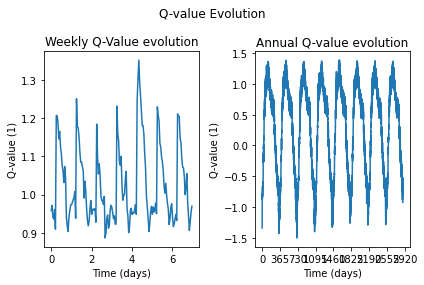

In [22]:
fig = qtime_subplot(transitions,agent, indexes)
if save_fig:
        tikzplotlib.save(os.path.join(IMAGES_PATH, "time_q_value_subplot.tikz"), figure=fig)
if save_fig_mat:
    fig.savefig(os.path.join(IMAGES_PATH,  "time_q_value_subplot.pdf"), 
                dpi=fig.dpi,  bbox_inches="tight")

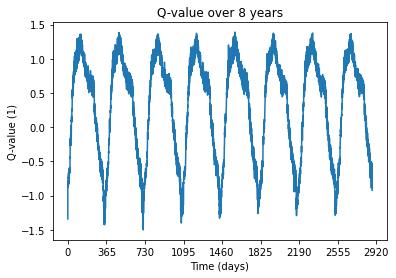

In [23]:
def qtime(transitions, agent, indexes, day_plot=False):
    predictor = agent.approximator._impl
    states = np.array([tr[0] for tr in transitions[0]])
    for i in range(1, len(transitions)):
        states += np.array([tr[0] for tr in transitions[i]])
    states = states/len(transitions)
    qvalues =predictor.predict(states)
    maxQ = np.max(qvalues, axis=1)
    time = np.linspace(0, states.shape[0]*60*60, states.shape[0])/3600/24
    fig, ax = plt.subplots()
    if day_plot:
        day = 90
        start = day*24
        end=start+24*7
        ax.plot(time[start:end]-day,maxQ[start:end])
    else:
        ax.plot(time[::12],maxQ[::12])
        xticklabels = [i*365 for i in range(0,9)]
        ax.set_xticks(xticklabels)
        

    ax.set_title("Q-value over 8 years")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Q-value (1)")
    plt.show()
    return fig
fig = qtime(transitions,agent, indexes)
if save_fig:
        tikzplotlib.save(os.path.join(IMAGES_PATH, "time_q_value.tikz"), figure=fig)
if save_fig_mat:
    fig.savefig(os.path.join(IMAGES_PATH,  "time_q_value.pdf"), 
                dpi=fig.dpi,  bbox_inches="tight")


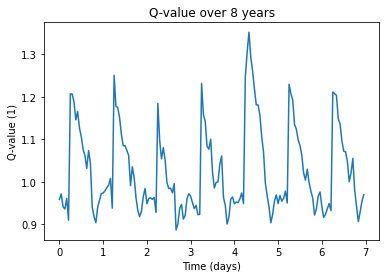

In [24]:
fig = qtime(transitions,agent, indexes, day_plot=True)
if save_fig:
        tikzplotlib.save(os.path.join(IMAGES_PATH, "time_q_value_week.tikz"), figure=fig)
if save_fig_mat:
    fig.savefig(os.path.join(IMAGES_PATH,  "time_q_value_week.pdf"), 
                dpi=fig.dpi,  bbox_inches="tight")

## Charging and Discharging Behaviour
In order to understand the be

In [25]:
def heatmap(transitions, var_index, var_name, episode_idx=None, indexes=None, charge=None, vmax=None, second_division=10):
    if episode_idx is None:
        t = [x for ep in transitions for x in ep]
    else:
        t = transitions[episode_idx]
    try:
        if charge is True and indexes is not None:
            t = [x for x in t if x[0][indexes["C_rate"]] < 0]
        elif charge is False and indexes is not None:
            t = [x for x in t if x[0][indexes["C_rate"]] > 0]
        else:
            t = [x for x in t]
    except Exception as e:
        print(e)

    states = [x[0] for x in t]
    states = np.array(states)
    actions = [x[1] for x in t]
    actions = [x[0] for x in actions]
    second_var = [x[0][var_index] for x in t]
    min_var = np.min(second_var)
    max_var = np.max(second_var)
    delta_step = (max_var - min_var) / second_division
    data = np.zeros((len(actions),2))
    data[:,0] = np.array(actions)
    data[:,1] = np.array(second_var)

    heatmap = np.zeros((11,second_division), dtype=int)
    for x in data:
        action = int(x[0])
        var_index = math.floor((x[1] - min_var)/delta_step)
        if var_index >= second_division:
            var_index = second_division - 1
        heatmap[action,var_index] += 1
    heatmap = heatmap.astype("float64")
    for i in range(heatmap.shape[1]):
        sum_col = np.sum(heatmap[:,i])
        heatmap[:,i] = np.array(heatmap[:,i])/sum_col
    log = False
    if log:
        ax =sns.heatmap(np.log(heatmap+1))
    else:
        # blues is a good palette
        cmap=cm.coolwarm
        xticks = np.linspace(0,1,second_division)
        xticks = [format(i,".2f") for i in xticks]
        ax =sns.heatmap(heatmap, vmin=0, vmax=vmax, xticklabels=xticks, 
                        yticklabels=np.linspace(0,10,11, dtype=int)/10, square=True,
                       cmap=cmap)
        plt.yticks(rotation=0)
        ax.invert_yaxis()
    ax.set(xlabel=var_name, ylabel='Actions')
    
    return ax

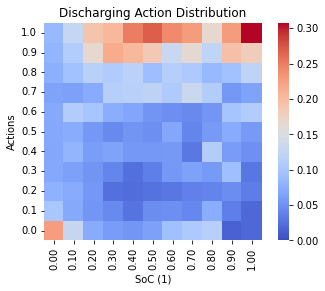

In [26]:
var = "SoC"
ax = heatmap(transitions, indexes[var], var, indexes=indexes , charge=False, second_division=11)
ax.set_title("Discharging Action Distribution")
ax.set_xlabel("SoC (1)")
ax.set_ylabel("Actions")
curr_fig = plt.gcf()
if save_fig:
    tikzplotlib.save(os.path.join(IMAGES_PATH, "discharge-heatmap.tikz"), figure=curr_fig)
if save_fig_mat:
    curr_fig.savefig(os.path.join(IMAGES_PATH,  "discharge_heatmap.pdf"), 
                dpi=fig.dpi,  bbox_inches="tight")

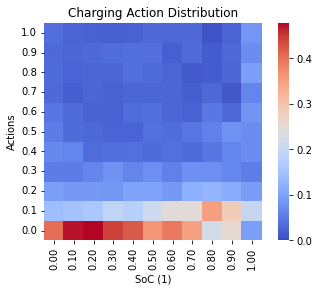

In [27]:
ax =heatmap(transitions, indexes[var], var, indexes=indexes , charge=True, second_division=11)
ax.set_title("Charging Action Distribution")
ax.set_xlabel("SoC (1)")
ax.set_ylabel("Actions")
curr_fig = plt.gcf()
if save_fig:
    tikzplotlib.save(os.path.join(IMAGES_PATH, "charge-heatmap.tikz"), figure=curr_fig)
if save_fig_mat:
    curr_fig.savefig(os.path.join(IMAGES_PATH,  "charge_heatmap.pdf"), 
                dpi=fig.dpi,  bbox_inches="tight")

## State Distribution
The next heatmap tells which are the most visited states wrt 2 different variables. This can give an idea on which are the desirable states for the agent.

In [28]:
def occurences(transitions,var_names, episode_idx=None, indexes=None, charge=None, 
              var_mins=[0,1], var_maxs=[0,1], var_lens=[10,10], log=False):
    if episode_idx is None:
        t = [x for ep in transitions for x in ep]
    else:
        t = transitions[episode_idx]
    try:
        if charge is True and indexes is not None:
            t = [x for x in t if x[0][indexes["C_rate"]] < 0]
        elif charge is False and indexes is not None:
            t = [x for x in t if x[0][indexes["C_rate"]] > 0]
        else:
            t = [x for x in t]
    except Exception as e:
        print(e)

    states = [x[0] for x in t]
    states = np.array(states)
    
    var1_name = var_names[0]
    var2_name = var_names[1]
    
    var1_index = indexes[var1_name]
    var2_index = indexes[var2_name]
    
    var1_min = var_mins[0]
    var2_min = var_mins[1]
    var1_max = var_maxs[0]
    var2_max = var_maxs[1]
    var1_len = var_lens[0]
    var2_len = var_lens[1]
    var1_span = np.linspace(var1_min, var1_max, var1_len)
    var2_span= np.linspace(var2_min, var2_max, var2_len)
    var1, var2 = np.meshgrid(var1_span, var2_span)

    #q_filtered_values = np.zeros((var1_len, var2_len))
    heatmap = np.zeros((var1_len, var2_len))

    for i in range(0,var1_len):
        start_1 = var1_min + i/var1_len*(var1_max-var1_min)
        end_1 =  var1_min + (i+1)/var1_len*(var1_max-var1_min)
        arr_var1 = states[:, indexes[var1_name]]
        #print(arr_var1)
        for j in range(0,var2_len):
            start_2 = var2_min + j/var2_len*(var2_max-var2_min)
            end_2 =  var2_min + (j+1)/var2_len*(var2_max-var2_min)
            arr_var2 = states[:,indexes[var2_name]]
            intersection_arr = (arr_var1 >= start_1)  & (arr_var1< end_1) & (arr_var2 >= start_2 ) & (arr_var2< end_2)
            occurences = intersection_arr[intersection_arr].size
            heatmap[i][j] = occurences
    heatmap = heatmap.transpose()
    if log:
        heatmap = np.log10(heatmap+1)
    import seaborn as sns
    import pandas as pd
    fig1, ax = plt.subplots()
    xticks = [format(i,".2f") for i in var1_span]
    yticks = [format(i,".2f") for i in var2_span]
    sns.heatmap(heatmap, ax=ax, cmap=cm.coolwarm, vmin=None,
                vmax=None, square=True, xticklabels=xticks, yticklabels=yticks)
    ax.set_xlabel(switch_dict[var1_name])
    ax.set_ylabel(switch_dict[var2_name])
    ax.invert_yaxis()
    if log:
        ax.set_title("SoC-DoD Log-Distribution")
    else:
        ax.set_title("SoC-DoD Distribution")
    
    return fig1, ax
    print("sum heatmap",np.sum(heatmap))
 

(691190, 9)
(691190, 9)


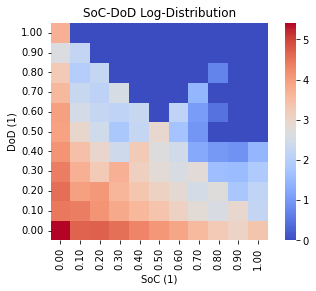

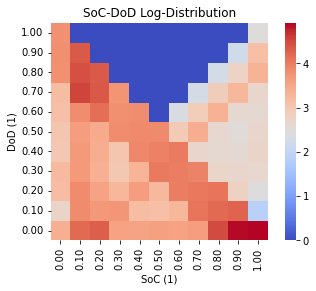

In [29]:
divs = 11
fig, ax =  occurences(transitions, ["SoC", "DoD"], indexes=indexes, var_mins=[0,0],
                      var_maxs=[1,1], var_lens=[divs,divs], log=True, episode_idx=None, charge=None)

fig2080, ax2080 = occurences(transitions_soc2080, ["SoC", "DoD"], indexes=indexes, var_mins=[0,0],
                             var_maxs=[1,1], var_lens=[divs,divs], log=True, episode_idx=None, charge=None)

if save_fig:
    tikzplotlib.save(os.path.join(IMAGES_PATH, "agent-log-distribution.tikz"), figure=fig)
    tikzplotlib.save(os.path.join(IMAGES_PATH, "2080-log-distribution.tikz"), figure=fig2080)
if save_fig_mat:
    fig.savefig(os.path.join(IMAGES_PATH,  "agent_log_distribution.pdf"), 
                dpi=fig.dpi,  bbox_inches="tight")
    fig2080.savefig(os.path.join(IMAGES_PATH,  "2080_log_distribution.pdf"), 
            dpi=fig.dpi,  bbox_inches="tight")